In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# For SARIMA Model
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings
# Suppressing the  warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [4]:
Sales_dataset = pd.read_csv(r"C:\Users\hbhat\OneDrive\Desktop\VScode\Project_Dominos\Dataset\Pizza_sales.csv")
Ingredients_dataset = pd.read_csv(r"C:\Users\hbhat\OneDrive\Desktop\VScode\Project_Dominos\Dataset\Pizza_ingredients.csv")

In [5]:
Sales_dataset.info()
Sales_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


,pizza_id,order_id,quantity,unit_price,total_price
count,48620.000000,48620.000000,48620.000000,48620.000000,48613.000000
mean,24310.500000,10701.479761,1.019622,16.494132,16.821494
std,14035.529381,6180.119770,0.143077,3.621789,4.437520
min,1.000000,1.000000,1.000000,9.750000,9.750000
25%,12155.750000,5337.000000,1.000000,12.750000,12.750000
50%,24310.500000,10682.500000,1.000000,16.500000,16.500000
75%,36465.250000,16100.000000,1.000000,20.250000,20.500000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000


In [6]:
Ingredients_dataset.info()
Ingredients_dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


,Items_Qty_In_Grams
count,514.000000
mean,30.564202
std,30.351623
min,5.000000
25%,10.000000
50%,20.000000
75%,40.000000
max,200.000000


## Missing values handling

In [7]:
Sales_dataset.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [8]:
Sales_dataset['total_price'].fillna(Sales_dataset['unit_price'] * Sales_dataset['quantity'], inplace=True)

In [9]:
Sales_dataset['pizza_category'].value_counts()

pizza_category
Classic    14572
Supreme    11771
Veggie     11442
Chicken    10812
Name: count, dtype: int64

In [10]:
Sales_dataset[Sales_dataset['pizza_category'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
426,427,181,mexicana_l,1,3/1/2015,18:49:32,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,428,182,brie_carre_s,1,3/1/2015,18:50:10,23.65,23.65,S,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,429,182,peppr_salami_l,1,3/1/2015,18:50:10,20.75,20.75,L,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,430,183,napolitana_m,1,3/1/2015,18:54:55,16.00,16.00,M,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,431,183,spin_pesto_l,1,3/1/2015,18:54:55,20.75,20.75,L,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza


In [11]:
Sales_dataset['pizza_name_id'].value_counts()

pizza_name_id
big_meat_s        1811
thai_ckn_l        1363
five_cheese_l     1358
four_cheese_l     1272
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       28
Name: count, Length: 91, dtype: int64

In [12]:
category_mapping = Sales_dataset[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

Sales_dataset['pizza_category'] = Sales_dataset['pizza_category'].fillna(Sales_dataset['pizza_name_id'].map(category_mapping))

## Filling missing ingredients

In [13]:
Sales_dataset[Sales_dataset['pizza_ingredients'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
580,581,254,five_cheese_l,1,4/1/2015,22:22:13,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
581,582,255,five_cheese_l,1,5/1/2015,11:23:35,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
582,583,255,green_garden_m,1,5/1/2015,11:23:35,16.0,16.0,M,Veggie,NaN,The Green Garden Pizza
583,584,255,hawaiian_l,1,5/1/2015,11:23:35,16.5,16.5,L,Classic,NaN,The Hawaiian Pizza
584,585,255,spinach_fet_m,1,5/1/2015,11:23:35,16.0,16.0,M,Veggie,NaN,The Spinach and Feta Pizza


In [14]:
ingredients_mapping = Sales_dataset[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

Sales_dataset['pizza_ingredients'] = Sales_dataset['pizza_ingredients'].fillna(Sales_dataset['pizza_name'].map(ingredients_mapping))

## Filling Missing Pizza Name Based on Pizza Ingredients:

In [15]:
Sales_dataset[Sales_dataset['pizza_name'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,689,303,pepperoni_s,1,5/1/2015,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,690,304,hawaiian_s,1,5/1/2015,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,691,304,mexicana_l,1,5/1/2015,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,692,305,pepperoni_l,1,5/1/2015,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,693,305,sicilian_s,1,5/1/2015,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN
693,694,305,spicy_ital_m,1,5/1/2015,20:35:40,16.50,16.50,M,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",NaN
694,695,306,big_meat_s,1,5/1/2015,20:37:40,12.00,12.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",NaN


In [16]:
len(Sales_dataset['pizza_ingredients'].value_counts())

32

In [17]:
ingredients_name_mapping = Sales_dataset[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
ingredients_name_mapping = ingredients_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()

Sales_dataset['pizza_name'] = Sales_dataset['pizza_name'].fillna(Sales_dataset['pizza_ingredients'].map(ingredients_name_mapping))

## Filling Missing Pizza Name ID Based on Pizza Name:

In [18]:
name_id_mapping = Sales_dataset[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
name_id_mapping = name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

Sales_dataset['pizza_name_id'] = Sales_dataset['pizza_name_id'].fillna(Sales_dataset['pizza_name'].map(name_id_mapping))

In [19]:
# check for null values
Sales_dataset.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

# Handling Missing Values in Ingredients Data:

In [20]:
Ingredients_dataset.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [21]:
Ingredients_dataset[Ingredients_dataset['Items_Qty_In_Grams'].isna()]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [22]:
Ingredients_dataset[Ingredients_dataset['pizza_name']=='The Brie Carre Pizza']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
22,brie_carre_s,The Brie Carre Pizza,Brie Carre Cheese,30.0
23,brie_carre_s,The Brie Carre Pizza,Prosciutto,30.0
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
25,brie_carre_s,The Brie Carre Pizza,Pears,10.0
26,brie_carre_s,The Brie Carre Pizza,Thyme,5.0
27,brie_carre_s,The Brie Carre Pizza,Garlic,5.0


In [23]:
Ingredients_dataset[Ingredients_dataset['pizza_ingredients']=='Sliced Ham']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [24]:
Ingredients_dataset[Ingredients_dataset['pizza_name_id']=='hawaiian_l']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
150,hawaiian_l,The Hawaiian Pizza,Pineapple,45.0
151,hawaiian_l,The Hawaiian Pizza,Mozzarella Cheese,30.0


## Calculateing the Mean for each Pizza Name ID:

In [25]:
mean_qty = Ingredients_dataset.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()

## Filling missing Items Quantity values using the Mean value:

In [26]:
Ingredients_dataset['Items_Qty_In_Grams'] = Ingredients_dataset['Items_Qty_In_Grams'].fillna(Ingredients_dataset['pizza_name_id'].map(mean_qty))

In [27]:
# Checking for remaining missing values in Items_Qty_In_Grams
remaining_missing_qty = Ingredients_dataset['Items_Qty_In_Grams'].isna().sum()
print(f"Remaining missing Items_Qty_In_Grams: {remaining_missing_qty}")

Remaining missing Items_Qty_In_Grams: 0


In [28]:
Ingredients_dataset.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

# 5. Merging Sales and Ingredients DataFrames:

In [29]:
merged_data = pd.merge(Sales_dataset, Ingredients_dataset, on='pizza_name_id', how='left')

In [30]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [31]:
merged_data.shape

(267576, 15)

In [32]:
merged_data.isnull().sum()

pizza_id               0
order_id               0
pizza_name_id          0
quantity               0
order_date             0
order_time             0
unit_price             0
total_price            0
pizza_size             0
pizza_category         0
pizza_ingredients_x    0
pizza_name_x           0
pizza_name_y           0
pizza_ingredients_y    0
Items_Qty_In_Grams     0
dtype: int64

In [33]:
merged_data[['pizza_ingredients_x','pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [34]:
merged_data[['pizza_name_x','pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [35]:
merged_data.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_data.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [36]:
merged_data.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [37]:
merged_data.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
dtype: int64

In [38]:
merged_data.duplicated().sum()

80204

In [39]:
# Droping duplicate rows from the dataset
merged_data = merged_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {merged_data.shape[0]}")

Number of rows after removing duplicates: 187372


In [40]:
merged_data1 = merged_data.copy()

In [41]:
# Summary statistics
merged_data.describe()

,pizza_id,order_id,quantity,unit_price,total_price,Items_Qty_In_Grams
count,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000
mean,24312.676030,10702.312405,1.019250,16.914338,17.244843,37.645900
std,14039.560378,6181.841091,0.141575,3.571451,4.419979,35.729459
min,1.000000,1.000000,1.000000,9.750000,9.750000,5.000000
25%,12166.750000,5344.000000,1.000000,12.750000,12.750000,15.000000
50%,24266.000000,10661.000000,1.000000,16.750000,16.750000,20.000000
75%,36494.250000,16112.250000,1.000000,20.500000,20.750000,45.000000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000,200.000000


In [42]:
# Summary statistics
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187372 non-null  int64  
 1   order_id            187372 non-null  int64  
 2   pizza_name_id       187372 non-null  object 
 3   quantity            187372 non-null  int64  
 4   order_date          187372 non-null  object 
 5   order_time          187372 non-null  object 
 6   unit_price          187372 non-null  float64
 7   total_price         187372 non-null  float64
 8   pizza_size          187372 non-null  object 
 9   pizza_category      187372 non-null  object 
 10  pizza_ingredients   187372 non-null  object 
 11  pizza_name          187372 non-null  object 
 12  Items_Qty_In_Grams  187372 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 20.0+ MB


In [43]:
merged_data.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
dtype: int64

Feature engineering 

In [44]:
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Applying the function to the 'order_date' column
merged_data['order_date'] = merged_data['order_date'].apply(extract_date)

In [45]:
# Extracting the day of the week
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek # day_name()
# Extracting the month
merged_data['month'] = merged_data['order_date'].dt.month # month_name()
# Createing a new column for the week number
merged_data['week'] = merged_data['order_date'].dt.isocalendar().week
# Extracting the year
merged_data['year'] = merged_data['order_date'].dt.year

In [46]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
import holidays

# using US holidays
us_holidays = holidays.US()

# Creating a 'holiday' column that indicates if the order_date was a holiday
merged_data['holiday'] = merged_data['order_date'].apply(lambda x: 1 if x in us_holidays else 0)

# Checking if the holiday flag works
merged_data[['order_date', 'holiday']].head()

,order_date,holiday
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
6,2015-01-01,1


In [48]:
merged_data[['order_date', 'holiday']].tail()

,order_date,holiday
267565,2015-12-31,0
267567,2015-12-31,0
267570,2015-12-31,0
267571,2015-12-31,0
267573,2015-12-31,0


Weekend vs weekday 

In [49]:
# Creating a 'promotional_period' flag for weekends 
merged_data['promotion'] = merged_data['order_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Checking if the promotion flag works
merged_data[['order_date', 'promotion']].head()

,order_date,promotion
0,2015-01-01,0
1,2015-01-01,0
2,2015-01-01,0
3,2015-01-01,0
6,2015-01-01,0


In [50]:
merged_data[merged_data['promotion'] == 1][['order_date', 'promotion']].head()

,order_date,promotion
1789,2015-01-03,1
1790,2015-01-03,1
1791,2015-01-03,1
1793,2015-01-03,1
1794,2015-01-03,1


In [51]:
merged_data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
day_of_week           0
month                 0
week                  0
year                  0
holiday               0
promotion             0
dtype: int64

In [52]:
merged_data.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0


In [53]:
# Aggregateing sales data by date
daily_sales = merged_data.groupby('order_date')['quantity'].sum().reset_index()
# daily_sales.set_index('order_date', inplace=True)
daily_sales

,order_date,quantity
0,2015-01-01,620
1,2015-01-02,631
2,2015-01-03,618
3,2015-01-04,414
4,2015-01-05,482
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


## Train-Test Split

In [54]:
print(merged_data.shape)

# Merged Sales and Ingredients DataFrames and Preprocessed the data to create a comprehensive pizza sales dataset
pizza_sales = merged_data

(187372, 19)


In [55]:
# Step 1: Filter the pizza_sales dataset for any week(week 7):
week_7_sales = merged_data[merged_data['week'] == 7]

# Step 2: Group by pizza name and sum the quantities
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()

# Step 3: List all grouped pizza names and their total quantities
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")

# Step 4: Calculate and print the total quantity sold in week 7
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 252 pizzas
The Big Meat Pizza: 99 pizzas
The Brie Carre Pizza: 48 pizzas
The Calabrese Pizza: 72 pizzas
The California Chicken Pizza: 212 pizzas
The Chicken Alfredo Pizza: 92 pizzas
The Chicken Pesto Pizza: 76 pizzas
The Classic Deluxe Pizza: 117 pizzas
The Five Cheese Pizza: 60 pizzas
The Four Cheese Pizza: 214 pizzas
The Greek Pizza: 155 pizzas
The Green Garden Pizza: 105 pizzas
The Hawaiian Pizza: 135 pizzas
The Italian Capocollo Pizza: 108 pizzas
The Italian Supreme Pizza: 144 pizzas
The Italian Vegetables Pizza: 103 pizzas
The Mediterranean Pizza: 53 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 112 pizzas
The Pepper Salami Pizza: 85 pizzas
The Pepperoni Pizza: 110 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 39 pizzas
The Prosciutto and Arugula Pizza: 65 pizzas
The Sicilian Pizza: 212 pizzas
The Soppressata Pizza: 76 pizzas
The Southwest Chicken Pizza: 205 pizzas
The Spicy Italian Pizza: 159 pizzas
The Spinach

## Exploratory data analysis of Sales data

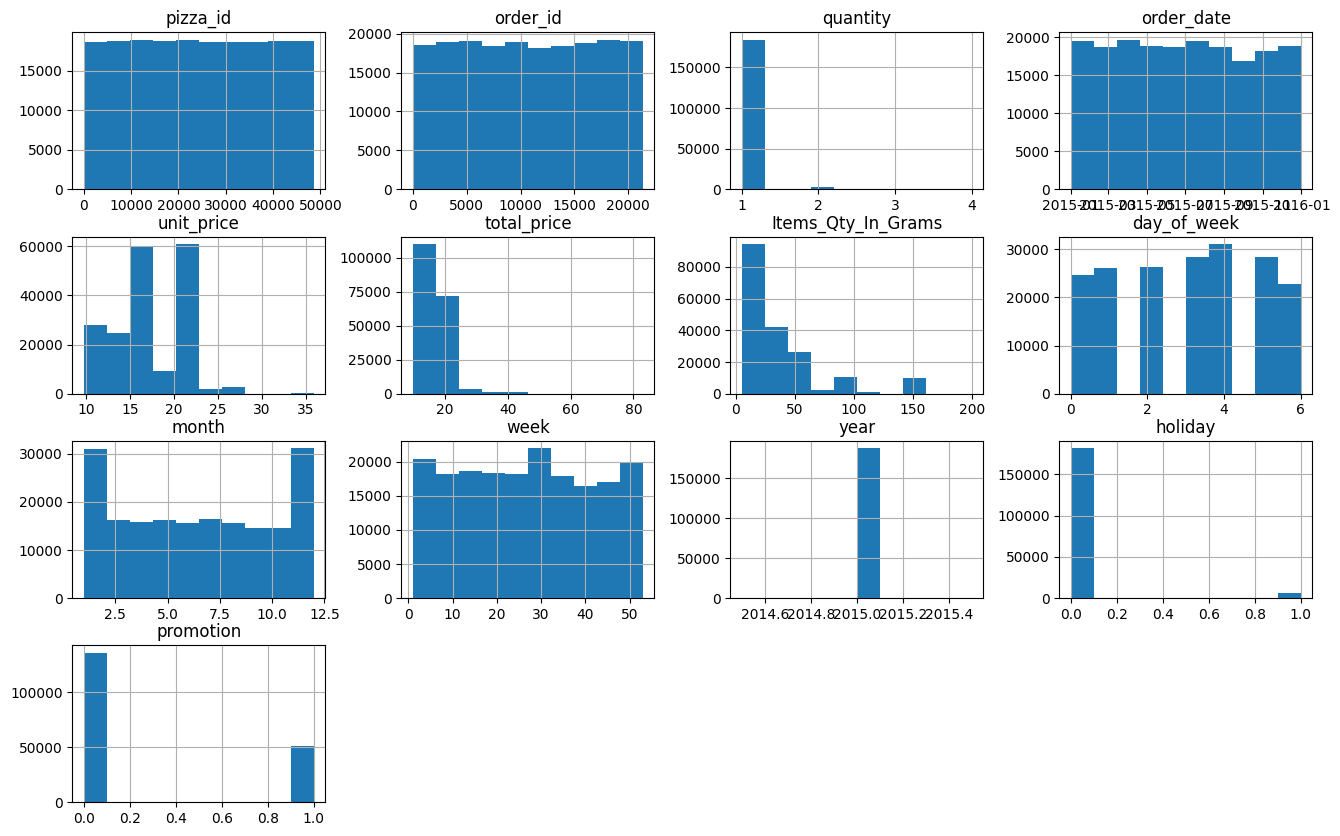

In [56]:
merged_data.hist(figsize=(16,10))
plt.show()

## Seasonal sales trend analysis

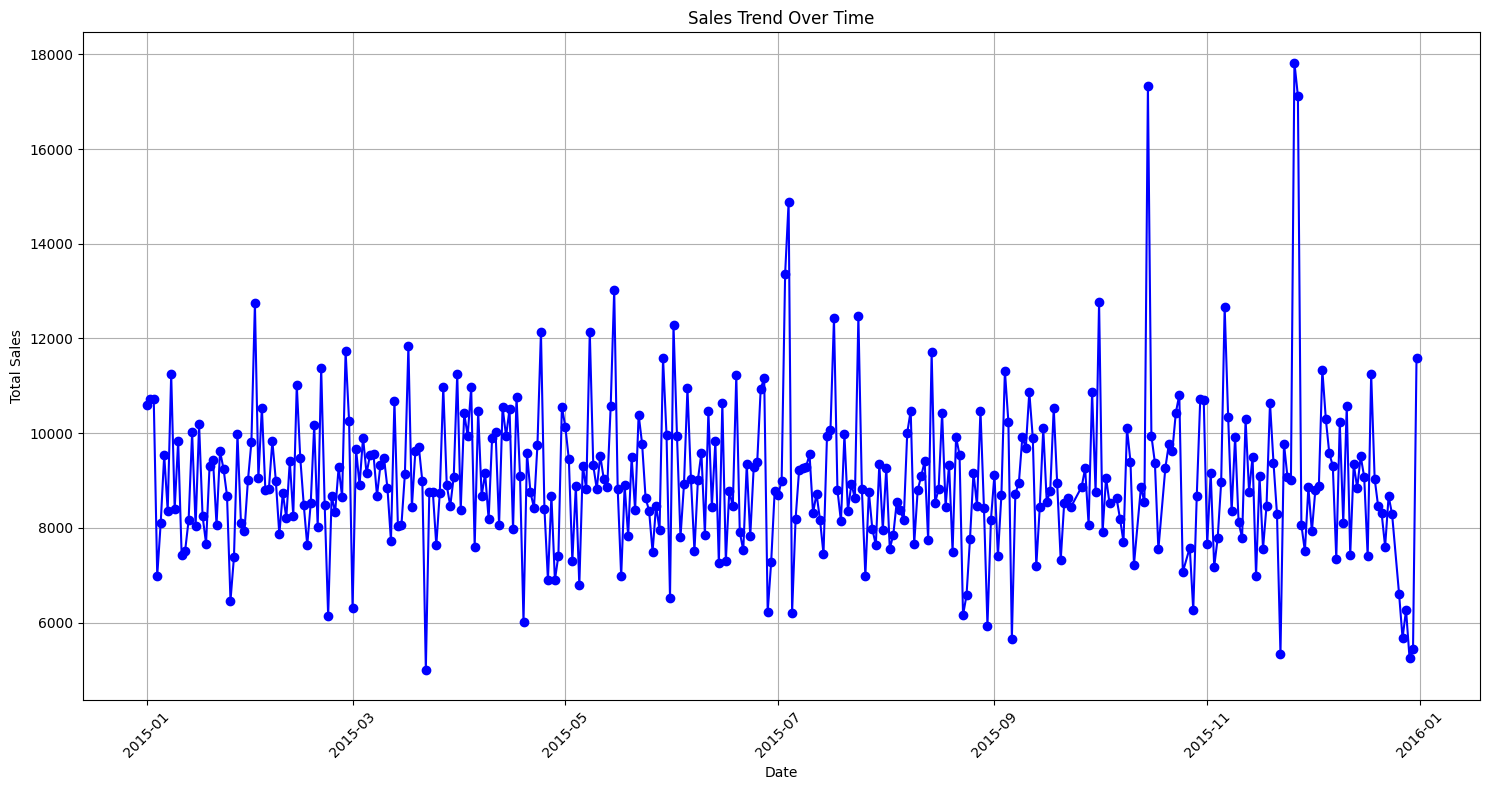

In [57]:
# 1. Sales Trend Over Time
sales_trend = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(15, 8))
plt.plot(sales_trend['order_date'], sales_trend['total_price'], marker='o', color='b')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

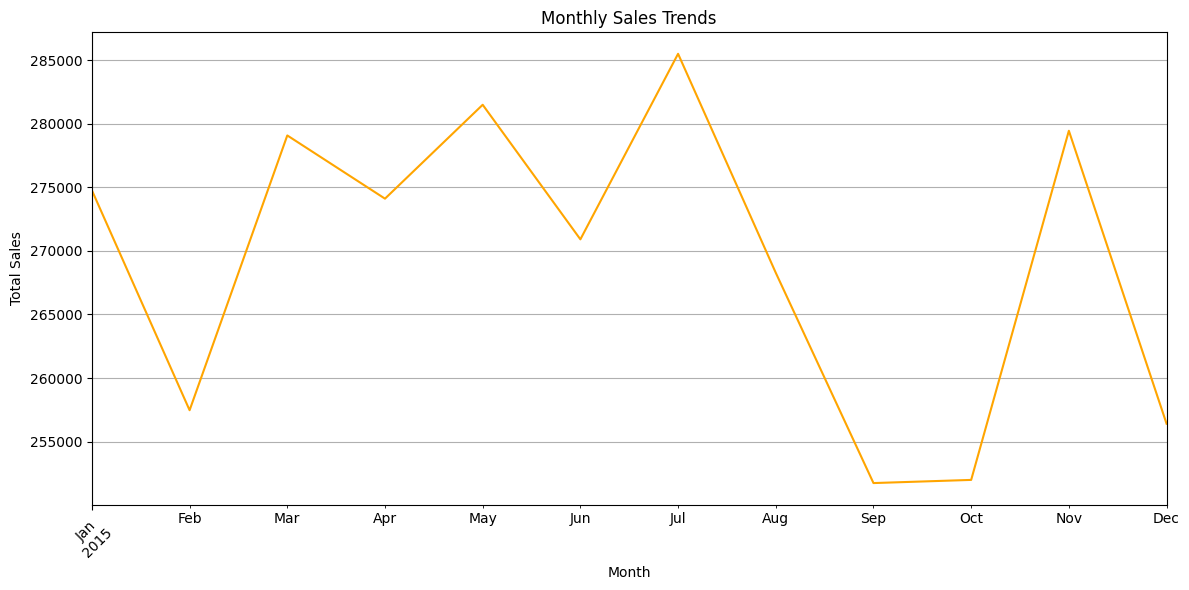

In [58]:
# 2. Monthly Sales Trends
merged_data['total_price'] = pd.to_numeric(merged_data['total_price'], errors='coerce')

monthly_sales = merged_data.resample('M', on='order_date')['total_price'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(color='orange')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

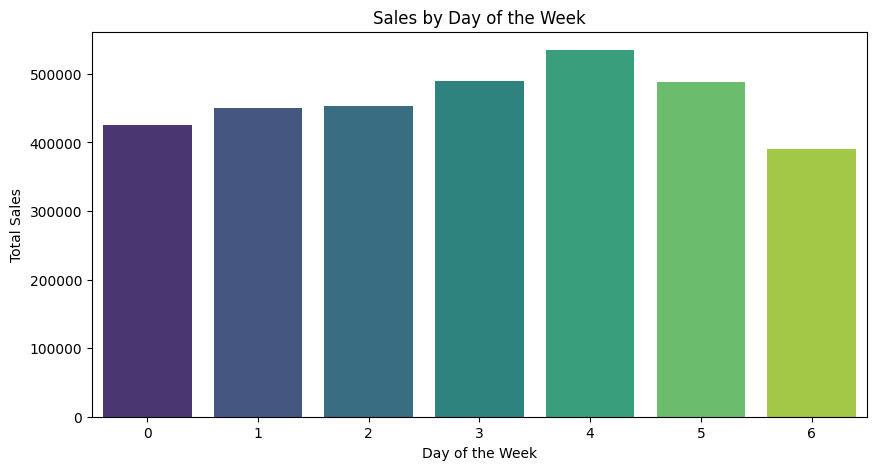

In [59]:
# Sales by Week 
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()

# Order days of the week
#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

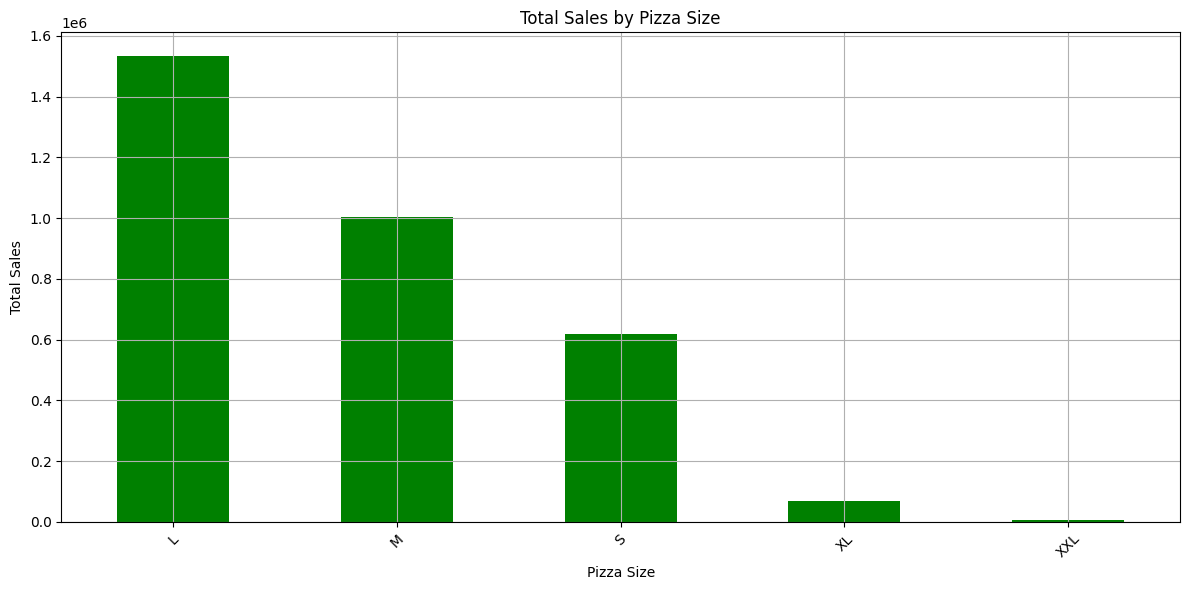

In [60]:
# 7. Total Sales by Pizza Size
size_sales = merged_data.groupby('pizza_size')['total_price'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
size_sales.plot(kind='bar', color='green')
plt.title('Total Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

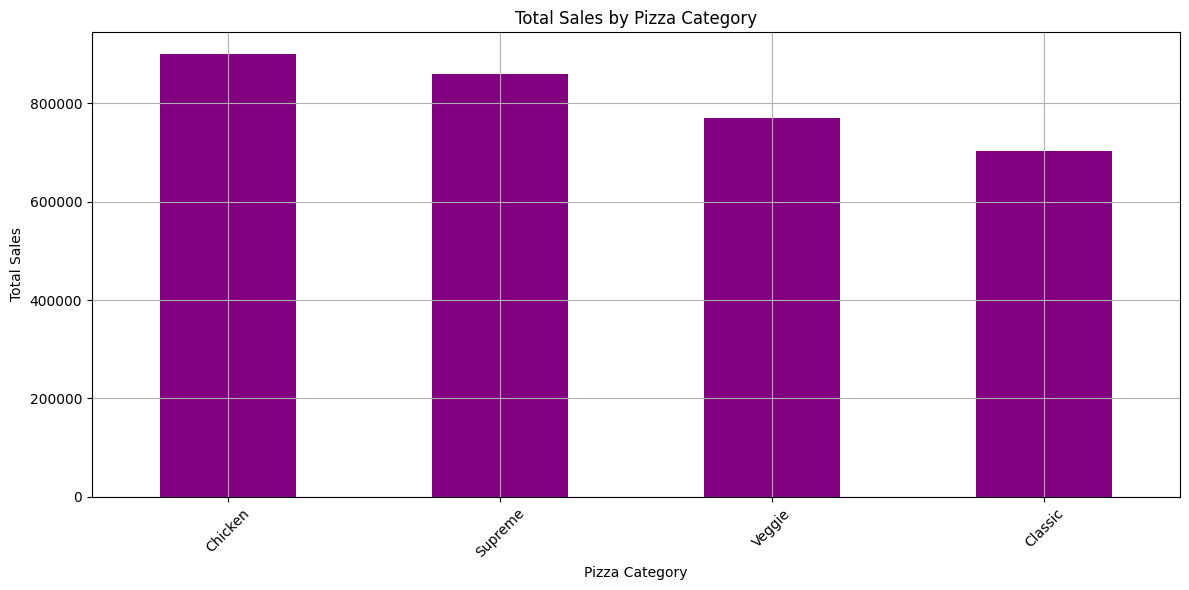

In [61]:
# 6. Total Sales by Pizza Category
category_sales = merged_data.groupby('pizza_category')['total_price'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
category_sales.plot(kind='bar', color='purple')
plt.title('Total Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

## Coreelation matrix of sales data

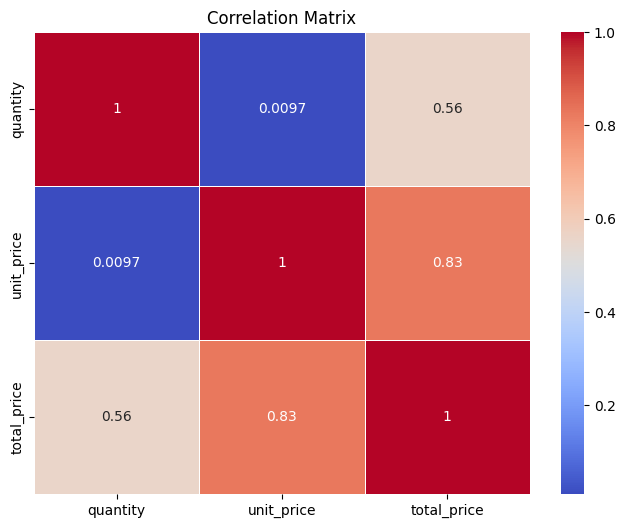

In [62]:
# Correlation matrix
corr_matrix = merged_data[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Outlier detection in sales data

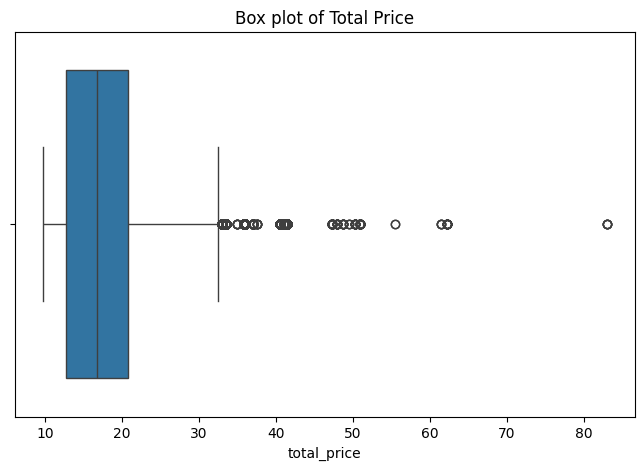

In [63]:
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_data, x='total_price')
plt.title('Box plot of Total Price')
plt.show()

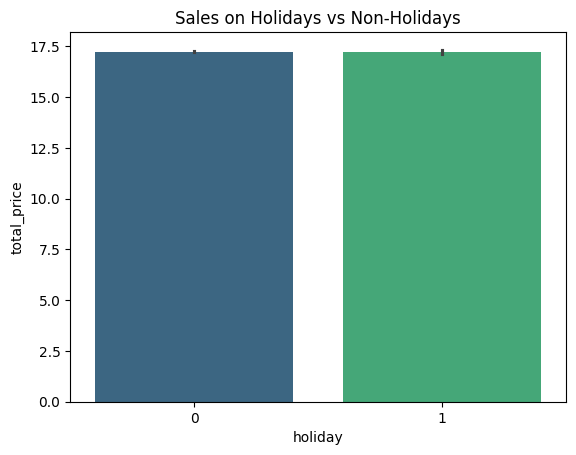

In [64]:
sns.barplot(x='holiday', y='total_price', data=merged_data, palette='viridis')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

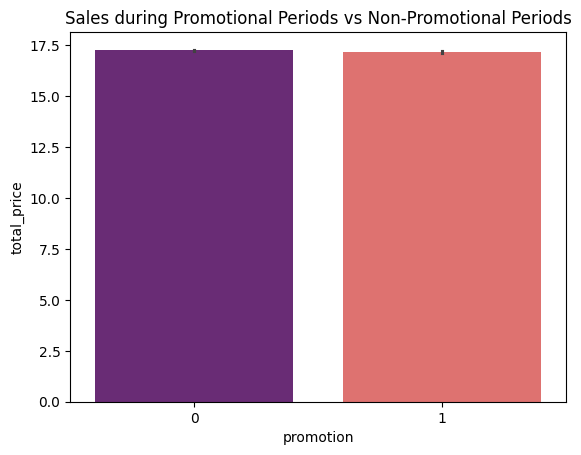

In [65]:
sns.barplot(x='promotion', y='total_price', data=merged_data, palette='magma')
plt.title('Sales during Promotional Periods vs Non-Promotional Periods')
plt.show()

## Model Selection

In [66]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# ARIMA Model
* p (AutoRegressive term): The number of past observations (lags) used to predict the future value.
* d (Differencing term): The number of times the data is differenced to make it stationary.
* q (Moving Average term): The number of past forecast errors used to improve future predictions.

Best ARIMA Model MAPE: 0.1894, Best Parameters: (2, 0, 2)
Predictions:
order_date
2015-10-19    3360.321191
2015-10-26    3549.683995
2015-11-02    3678.220175
2015-11-09    3709.912117
2015-11-16    3680.301676
2015-11-23    3638.563240
2015-11-30    3613.695210
2015-12-07    3609.896724
2015-12-14    3617.772284
2015-12-21    3626.756172
2015-12-28    3631.421980
Name: predicted_mean, dtype: float64


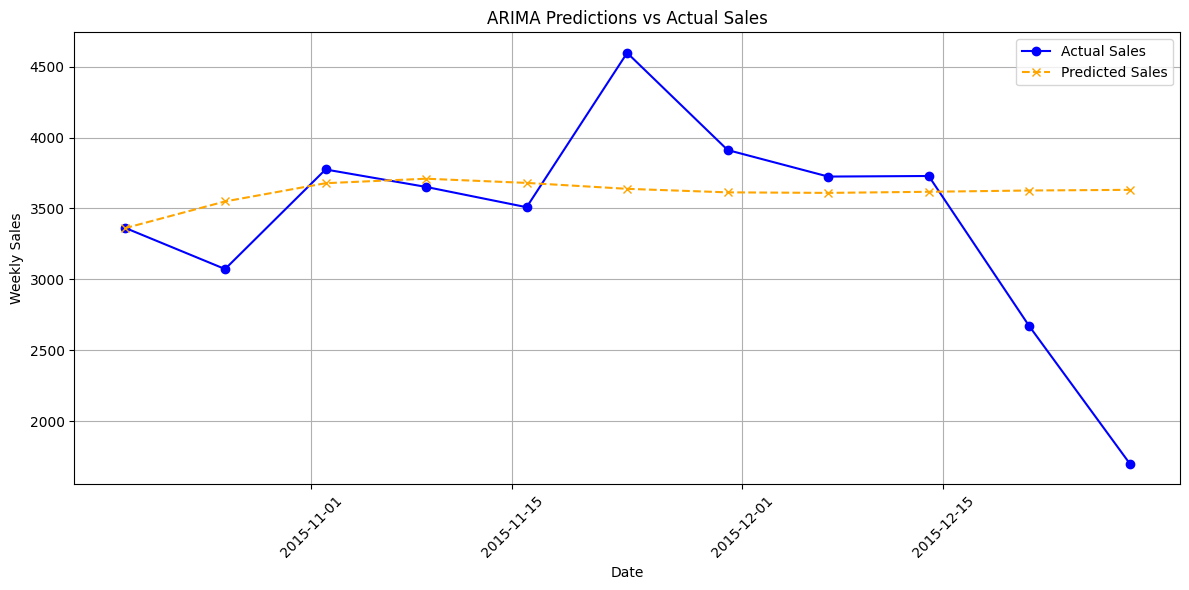

In [68]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# SARIMA (Seasonal ARIMA)
* P (Seasonal AutoRegressive term): The number of past seasonal values used for prediction.
* D (Seasonal Differencing term): The number of seasonal differencing applied to make data stationary.
* Q (Seasonal Moving Average term): The number of past seasonal forecast errors used for prediction.
* S (Seasonal Period): The length of the seasonal cycle (e.g., 12 for yearly seasonality in monthly data).

Best SARIMA Model MAPE: 0.1849
Predictions:
order_date
2015-10-19    3251.125741
2015-10-26    3647.292211
2015-11-02    3407.561453
2015-11-09    2750.099059
2015-11-16    3590.353378
2015-11-23    3084.831359
2015-11-30    3327.425386
2015-12-07    3155.897063
2015-12-14    3475.639745
2015-12-21    3266.273799
2015-12-28    2592.941517
Name: predicted_mean, dtype: float64


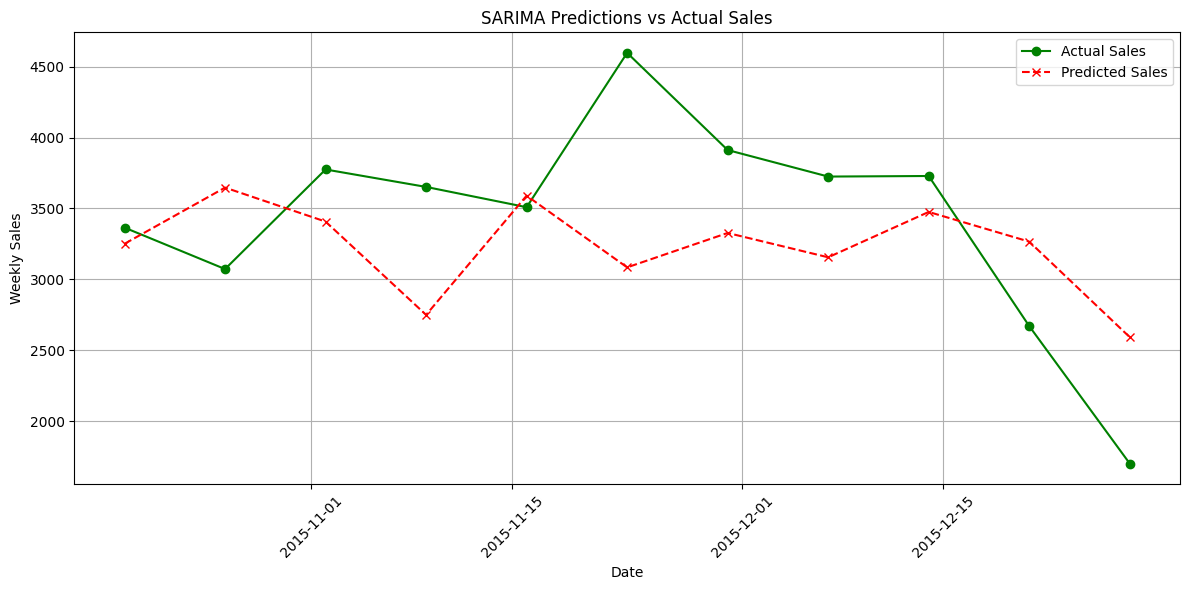

In [82]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape

# Train and evaluate the SARIMA model
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='green', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='red', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Prophet model for handling time series data and seasonal trends analysis


In [70]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


17:31:16 - cmdstanpy - INFO - Chain [1] start processing
17:31:16 - cmdstanpy - INFO - Chain [1] done processing


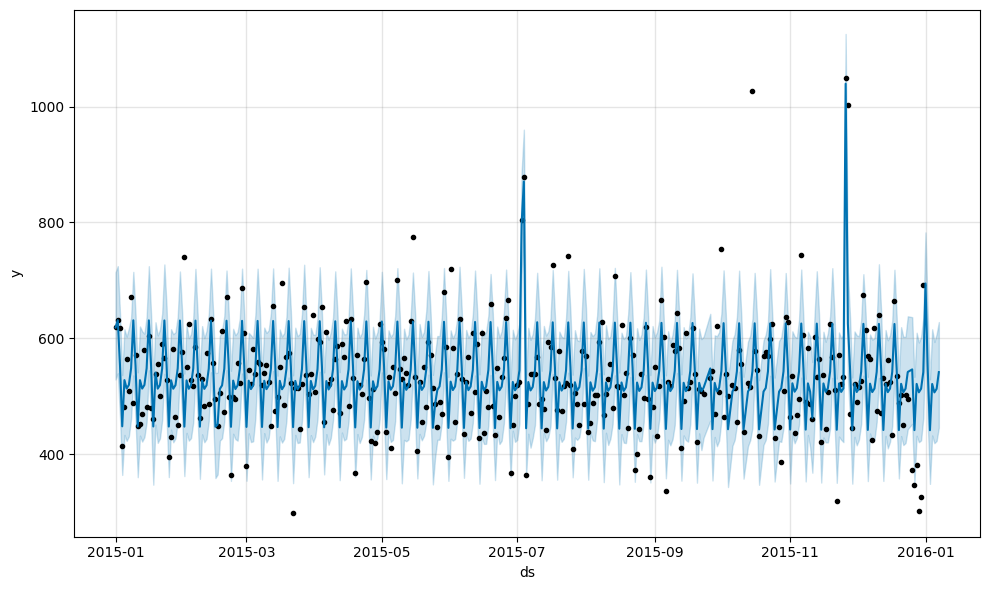

In [71]:
# Prophet model
daily_sales['order_date'] = pd.to_datetime(daily_sales['order_date'])

# renameing the columns to 'ds' for dates and 'y' for the target values
prophet_data = daily_sales.rename(columns={'order_date': 'ds', 'quantity': 'y'})

# Model fiting
prophet_model = Prophet()
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(prophet_data)

# Future forecast for the next 7 days
future_dates = prophet_model.make_future_dataframe(periods=7)
prophet_forecast = prophet_model.predict(future_dates)

# Displaying the forecast
fig = prophet_model.plot(prophet_forecast)

17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet Model MAPE: 0.1962
Predictions:
ds
2015-10-19    3619.506283
2015-10-26    3618.034527
2015-11-02    3616.562771
2015-11-09    3615.091015
2015-11-16    3613.619259
2015-11-23    3612.147503
2015-11-30    3610.675747
2015-12-07    3609.203991
2015-12-14    3607.732235
2015-12-21    3606.260479
2015-12-28    3604.788723
dtype: float64


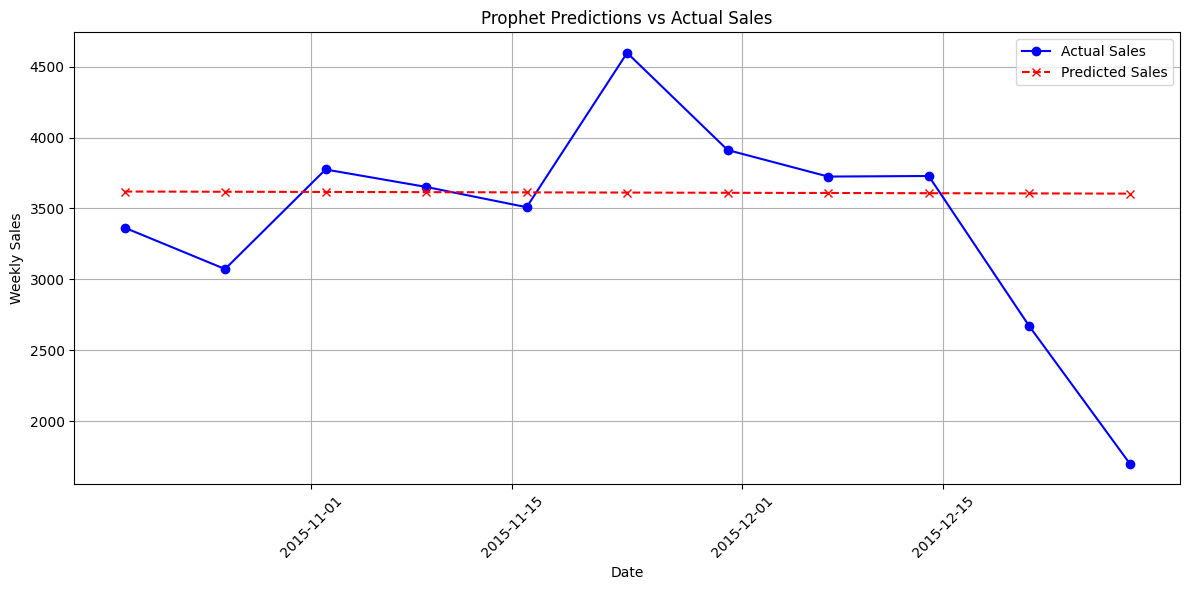

In [72]:
# Pizza sales by week
def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # Prophet requires columns 'ds' for date and 'y' for the target variable
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)
    
    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='red', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Regression Model

Best Regression Model MAPE: 0.1911
Predictions:
order_date
2015-10-19    3545.287304
2015-10-26    3530.562085
2015-11-02    3552.361183
2015-11-09    3537.635964
2015-11-16    3522.910745
2015-11-23    3508.185526
2015-11-30    3493.460307
2015-12-07    3515.259404
2015-12-14    3500.534185
2015-12-21    3485.808966
2015-12-28    3471.083747
dtype: float64


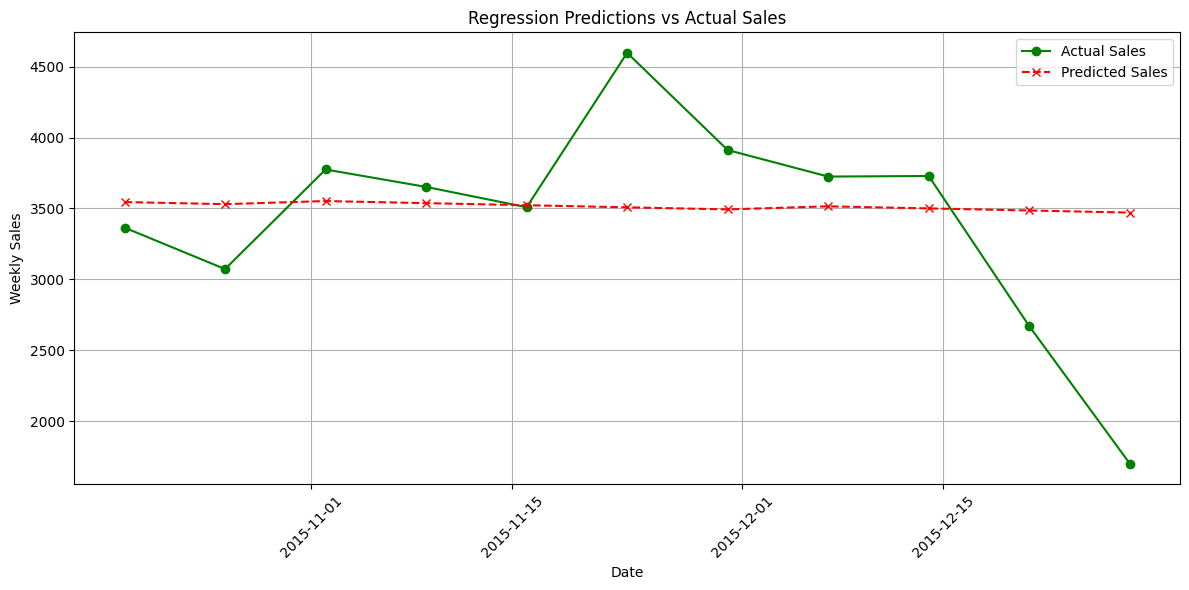

In [73]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

# Feature Engineering for Regression
def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)
pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Prepareing data for Regression
X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# Best Regression Model Training and Output
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)
    
    print(f"Best Regression Model MAPE: {regression_mape:.4f}")
    return predictions, regression_mape

# Train and evaluate the Regression model
regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
regression_predictions = pd.Series(regression_predictions, index=test['order_date'])

print("Predictions:")
print(regression_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], y_test, label='Actual Sales', color='green', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='red', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Long short term memory model 

In [74]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Best LSTM Model MAPE: 0.2360
Predictions:
order_date
2015-11-09    3455.542969
2015-11-16    3519.566406
2015-11-23    3664.630371
2015-11-30    3818.044678
2015-12-07    3927.416260
2015-12-14    4048.660645
2015-12-21    3774.508789
2015-12-28    3490.397705
dtype: float32


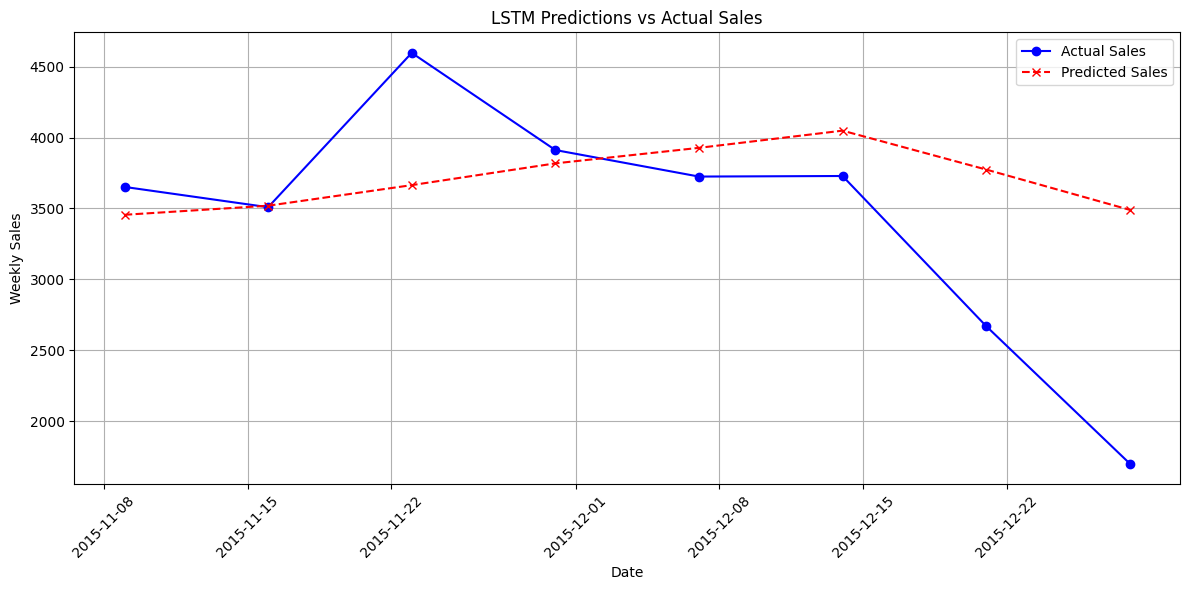

In [75]:
# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)
    
    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='red', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Predicted sales for the week 

In [83]:

# ARIMA Model sales prediction for the week:

# Aggregate pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Function to forecast sales for each pizza type using ARIMA
def forecast_sales_per_pizza_type_arima(pizza_type, train, periods=1):
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting next week's sales for each pizza type using ARIMA
def forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    # Total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # train test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using ARIMA
        pizza_type, forecast = forecast_sales_per_pizza_type_arima(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# predicting pizza sales for the next week using ARIMA
next_week_pizza_sales_forecasts_arima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the predicted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Predicted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_arima.items():
    forecast = int(forecast[0])
    next_week_pizza_sales_forecasts_arima[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Predicted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 92 pizzas
bbq_ckn_m: 91 pizzas
bbq_ckn_s: 27 pizzas
big_meat_s: 107 pizzas
brie_carre_s: 37 pizzas
calabrese_m: 43 pizzas
calabrese_s: 8 pizzas
cali_ckn_l: 80 pizzas
cali_ckn_m: 81 pizzas
cali_ckn_s: 39 pizzas
ckn_alfredo_l: 14 pizzas
ckn_alfredo_m: 61 pizzas
ckn_alfredo_s: 9 pizzas
ckn_pesto_l: 31 pizzas
ckn_pesto_m: 21 pizzas
ckn_pesto_s: 15 pizzas
classic_dlx_l: 26 pizzas
classic_dlx_m: 72 pizzas
classic_dlx_s: 46 pizzas
five_cheese_l: 56 pizzas
four_cheese_l: 114 pizzas
four_cheese_m: 45 pizzas
green_garden_l: 10 pizzas
green_garden_m: 25 pizzas
green_garden_s: 46 pizzas
hawaiian_l: 50 pizzas
hawaiian_m: 24 pizzas
hawaiian_s: 52 pizzas
ital_cpcllo_l: 55 pizzas
ital_cpcllo_m: 30 pizzas
ital_cpcllo_s: 23 pizzas
ital_supr_l: 52 pizzas
ital_supr_m: 66 pizzas
ital_supr_s: 14 pizzas
ital_veggie_l: 20 pizzas
ital_veggie_m: 36 pizzas
ital_veggie_s: 16 pizzas
mediterraneo_l: 36 pizzas
mediterraneo_m: 23 pizzas
mediterraneo_s:

# SARIMA Model sales prediction for the week

In [84]:


# Aggregateing pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    
    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]
        
        # train test data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the predicted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Predicted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Displaying the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Predicted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 82 pizzas
bbq_ckn_m: 95 pizzas
bbq_ckn_s: 39 pizzas
big_meat_s: 89 pizzas
brie_carre_s: 56 pizzas
calabrese_m: 40 pizzas
calabrese_s: 6 pizzas
cali_ckn_l: 83 pizzas
cali_ckn_m: 56 pizzas
cali_ckn_s: 38 pizzas
ckn_alfredo_l: 9 pizzas
ckn_alfredo_m: 58 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 31 pizzas
ckn_pesto_m: 14 pizzas
ckn_pesto_s: 14 pizzas
classic_dlx_l: 19 pizzas
classic_dlx_m: 72 pizzas
classic_dlx_s: 39 pizzas
five_cheese_l: 55 pizzas
four_cheese_l: 149 pizzas
four_cheese_m: 44 pizzas
green_garden_l: 2 pizzas
green_garden_m: 28 pizzas
green_garden_s: 46 pizzas
hawaiian_l: 48 pizzas
hawaiian_m: 20 pizzas
hawaiian_s: 46 pizzas
ital_cpcllo_l: 60 pizzas
ital_cpcllo_m: 37 pizzas
ital_cpcllo_s: 26 pizzas
ital_supr_l: 61 pizzas
ital_supr_m: 49 pizzas
ital_supr_s: 3 pizzas
ital_veggie_l: 16 pizzas
ital_veggie_m: 25 pizzas
ital_veggie_s: 16 pizzas
mediterraneo_l: 37 pizzas
mediterraneo_m: 29 pizzas
mediterraneo_s: 18

## Prophet model predicted sales for the week 

In [78]:
# Function to predict sales for each pizza type using Prophet
def forecast_sales_per_pizza_type_prophet(pizza_type, train, periods=1):
    # Prepare the data for Prophet
    train_prophet = train.reset_index().rename(columns={'week': 'ds', 'quantity': 'y'})
    
    # Fit the Prophet model
    model = Prophet()
    model.fit(train_prophet)

    # Create a DataFrame to hold the future dates
    future = model.make_future_dataframe(periods=periods)
    
    # Forecasting
    forecast = model.predict(future)
    return pizza_type, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

# Forecasting next week's sales for each pizza type using Prophet
def forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza, periods=7):
    pizza_type_forecasts = {}

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Train-test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]

        # Forecast sales using Prophet
        pizza_type, forecast = forecast_sales_per_pizza_type_prophet(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast['yhat'].sum()  # Total forecasted sales for the week
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, next_week_start, next_week_end

# Forecasting pizza sales for the next week using Prophet
next_week_pizza_sales_forecasts_prophet, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Predicted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = sum(next_week_pizza_sales_forecasts_prophet.values())

for pizza_type, forecast in next_week_pizza_sales_forecasts_prophet.items():
    print(f'{pizza_type}: {int(forecast)} pizzas')

print(f"Total quantity of units sold in the predicted week: {int(total_forecasted_quantity)} pizzas")

17:33:02 - cmdstanpy - INFO - Chain [1] start processing
17:33:03 - cmdstanpy - INFO - Chain [1] done processing
17:33:03 - cmdstanpy - INFO - Chain [1] start processing
17:33:03 - cmdstanpy - INFO - Chain [1] done processing
17:33:03 - cmdstanpy - INFO - Chain [1] start processing
17:33:03 - cmdstanpy - INFO - Chain [1] done processing
17:33:03 - cmdstanpy - INFO - Chain [1] start processing
17:33:03 - cmdstanpy - INFO - Chain [1] done processing
17:33:03 - cmdstanpy - INFO - Chain [1] start processing
17:33:03 - cmdstanpy - INFO - Chain [1] done processing
17:33:04 - cmdstanpy - INFO - Chain [1] start processing
17:33:04 - cmdstanpy - INFO - Chain [1] done processing
17:33:04 - cmdstanpy - INFO - Chain [1] start processing
17:33:04 - cmdstanpy - INFO - Chain [1] done processing
17:33:04 - cmdstanpy - INFO - Chain [1] start processing
17:33:04 - cmdstanpy - INFO - Chain [1] done processing
17:33:04 - cmdstanpy - INFO - Chain [1] start processing
17:33:04 - cmdstanpy - INFO - Chain [1]

Predicted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 607 pizzas
bbq_ckn_m: 658 pizzas
bbq_ckn_s: 187 pizzas
big_meat_s: 766 pizzas
brie_carre_s: 275 pizzas
calabrese_m: 309 pizzas
calabrese_s: 55 pizzas
cali_ckn_l: 603 pizzas
cali_ckn_m: 563 pizzas
cali_ckn_s: 279 pizzas
ckn_alfredo_l: 111 pizzas
ckn_alfredo_m: 450 pizzas
ckn_alfredo_s: 70 pizzas
ckn_pesto_l: 218 pizzas
ckn_pesto_m: 165 pizzas
ckn_pesto_s: 149 pizzas
classic_dlx_l: 185 pizzas
classic_dlx_m: 520 pizzas
classic_dlx_s: 323 pizzas
five_cheese_l: 379 pizzas
four_cheese_l: 862 pizzas
four_cheese_m: 304 pizzas
green_garden_l: 77 pizzas
green_garden_m: 166 pizzas
green_garden_s: 362 pizzas
hawaiian_l: 385 pizzas
hawaiian_m: 208 pizzas
hawaiian_s: 366 pizzas
ital_cpcllo_l: 417 pizzas
ital_cpcllo_m: 180 pizzas
ital_cpcllo_s: 153 pizzas
ital_supr_l: 391 pizzas
ital_supr_m: 473 pizzas
ital_supr_s: 105 pizzas
ital_veggie_l: 94 pizzas
ital_veggie_m: 239 pizzas
ital_veggie_s: 98 pizzas
mediterraneo_l: 255 pizzas
mediterr

## Model Evaluation

In [85]:
import pandas as pd

# Model results as a dictionary
model_performance = {
    'Model': ['SARIMA', 'ARIMA', 'Regression', 'Prophet', 'LSTM'],
    'MAPE': [0.1849, 0.1894, 0.1911, 0.1962, 0.2452]
}

# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# # Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')

# Display table
df_performance

,Model,MAPE,Rank,Best/Worst
0,SARIMA,0.1849,1.0,Best
1,ARIMA,0.1894,2.0,
2,Regression,0.1911,3.0,
3,Prophet,0.1962,4.0,
4,LSTM,0.2452,5.0,Worst


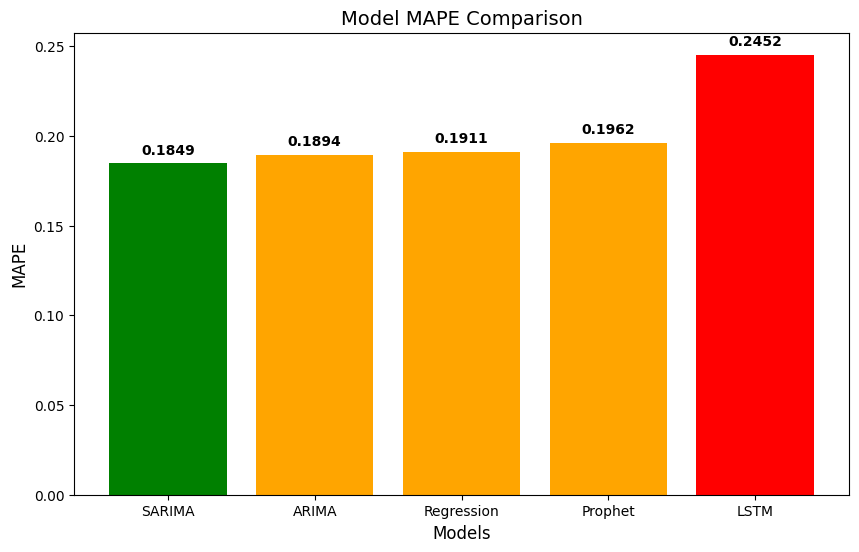

In [86]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['SARIMA', 'ARIMA', 'Regression', 'Prophet', 'LSTM']
mapes = [0.1849, 0.1894, 0.1911, 0.1962, 0.2452]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'orange', 'orange', 'orange', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()

## SARIMA model evaluation

In [87]:
import numpy as np
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          quantity   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -249.196
Date:                           Mon, 04 Nov 2024   AIC                            508.391
Time:                                   17:37:15   BIC                            516.023
Sample:                               12-29-2014   HQIC                           510.994
                                    - 10-12-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3901      0.258     -1.514      0.130      -0.895       0.115
ma.L1         -0.4667      0.256     -1.826

## Hyperparameter Tuning for SARIMA

In [ ]:
# Useing auto_arima to find the best parameters
auto_model = auto_arima(train, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=511.689, Time=0.57 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=514.308, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=505.442, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=505.959, Time=0.25 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=505.737, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=506.854, Time=0.35 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=507.009, Time=0.32 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=505.011, Time=0.15 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=507.009, Time=0.71 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=1.05 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=515.380, Time=0.60 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=506.879, Time=0.54 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=506.392, Time=0.49 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=508.027, Time=0.63 sec
 ARIMA(1,1,0)(0,1,1)[7] intercept   : AIC=505.395, 

In [ ]:
import pickle # Importing pickle for saving the model

# Save the model to a file using pickle
model_filename = 'best_sarima_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(auto_model, file)
print(f"Model saved as {model_filename}")

Model saved as best_sarima_model.pkl


In [ ]:
# Load the model from the file using pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")

Model loaded successfully.


## Purchase order predictions

In [ ]:
# Loading the model
model_filename = 'best_sarima_model.pkl'
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Forecasting function
def forecast_sales(loaded_model, periods):
    forecast = loaded_model.predict(n_periods=periods)
    return forecast

forecasted_sales = forecast_sales(loaded_model, periods=7)
print(forecasted_sales)

2015-10-19    3213.580069
2015-10-26    3760.607879
2015-11-02    3370.263286
2015-11-09    2900.604066
2015-11-16    3582.850120
2015-11-23    3194.747230
2015-11-30    3349.252530
Freq: W-MON, dtype: float64


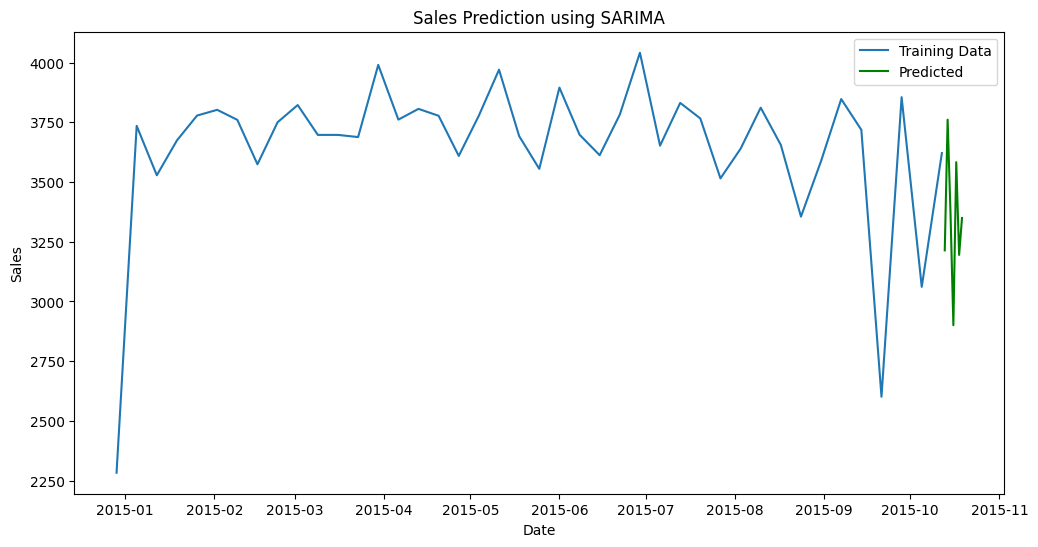

In [ ]:
# Loading the best model
with open('best_sarima_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Forecasting the data
n_forecast = 7
forecast = best_model.predict(n_periods=n_forecast)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=n_forecast), forecast, label='Predicted', color='green')
plt.title('Sales Prediction using SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [88]:
# Displaying the total quantity of predicted ingredients

# map predicted sales, and calculating the total ingredient quantity
ingredients_predicted = Ingredients_dataset.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts_arima)
ingredients_predicted['total_ingredient_qty_in_Kg'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']/1000

# Sum of the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty_in_Kg'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
print(ingredient_totals)
ingredients_predicted

Total quantity of predicted ingredients for the following week:
{'?duja Salami': 2.54, 'Alfredo Sauce': 1.2850000000000001, 'Anchovies': 3.295, 'Artichokes': 10.485, 'Arugula': 0.705, 'Asiago Cheese': 6.2, 'Bacon': 28.67, 'Barbecue Sauce': 2.425, 'Barbecued Chicken': 6.95, 'Beef Chuck Roast': 10.66, 'Blue Cheese': 1.68, 'Brie Carre Cheese': 1.11, 'Calabrese Salami': 15.1, 'Capocollo': 62.1, 'Caramelized Onions': 0.592, 'Chicken': 80.8, 'Chipotle Sauce': 7.33, 'Chorizo Sausage': 5.35, 'Cilantro': 3.665, 'Coarse Sicilian Salami': 11.48, 'Corn': 24.54, 'Eggplant': 2.96, 'Feta Cheese': 9.97, 'Fontina Cheese': 5.84, 'Friggitello Peppers': 0.635, 'Garlic': 23.835, 'Genoa Salami': 8.790000000000001, 'Goat Cheese': 12.94, 'Gorgonzola Piccante Cheese': 5.46, 'Gouda Cheese': 4.41, 'Green Olives': 4.745, 'Green Peppers': 6.84, 'Italian Sausage': 1.07, 'Jalapeno Peppers': 5.87, 'Kalamata Olives': 3.07, 'Luganega Sausage': 5.74, 'Mozzarella Cheese': 11.559999999999999, 'Mushrooms': 25.86, 'Onions':

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty_in_Kg
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,92,3.680
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,92,1.380
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,92,1.840
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,92,2.760
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,92,5.520
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,33,0.660
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,33,0.660
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,33,0.330
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,33,0.495


In [89]:
ingredient_totals

{'?duja Salami': 2.54,
 'Alfredo Sauce': 1.2850000000000001,
 'Anchovies': 3.295,
 'Artichokes': 10.485,
 'Arugula': 0.705,
 'Asiago Cheese': 6.2,
 'Bacon': 28.67,
 'Barbecue Sauce': 2.425,
 'Barbecued Chicken': 6.95,
 'Beef Chuck Roast': 10.66,
 'Blue Cheese': 1.68,
 'Brie Carre Cheese': 1.11,
 'Calabrese Salami': 15.1,
 'Capocollo': 62.1,
 'Caramelized Onions': 0.592,
 'Chicken': 80.8,
 'Chipotle Sauce': 7.33,
 'Chorizo Sausage': 5.35,
 'Cilantro': 3.665,
 'Coarse Sicilian Salami': 11.48,
 'Corn': 24.54,
 'Eggplant': 2.96,
 'Feta Cheese': 9.97,
 'Fontina Cheese': 5.84,
 'Friggitello Peppers': 0.635,
 'Garlic': 23.835,
 'Genoa Salami': 8.790000000000001,
 'Goat Cheese': 12.94,
 'Gorgonzola Piccante Cheese': 5.46,
 'Gouda Cheese': 4.41,
 'Green Olives': 4.745,
 'Green Peppers': 6.84,
 'Italian Sausage': 1.07,
 'Jalapeno Peppers': 5.87,
 'Kalamata Olives': 3.07,
 'Luganega Sausage': 5.74,
 'Mozzarella Cheese': 11.559999999999999,
 'Mushrooms': 25.86,
 'Onions': 2.87,
 'Oregano': 1.24,
 

In [90]:
# Saveing the ingredient totals to a DataFrame
ingredient_totals_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredients', 'Total Quantity (Kg)'])
ingredient_totals_df.to_csv('predicted_ingredients.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredients.csv'")

Predicted ingredient totals saved to 'predicted_ingredients.csv'


<Figure size 1200x800 with 0 Axes>

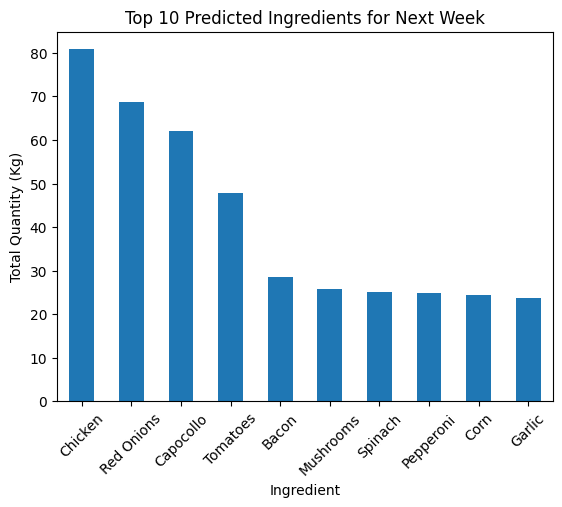

In [ ]:
# Visualizing the total quantities of ingredients
plt.figure(figsize=(12, 8))
ingredient_totals_df.nlargest(10, 'Total Quantity (Kg)').plot(kind='bar', x='Ingredients', y='Total Quantity (Kg)', legend=False)
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.ylabel('Total Quantity (Kg)')
plt.xticks(rotation=45)
plt.show()

In [133]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredients.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (Kg)
0,?duja Salami,2.540
1,Alfredo Sauce,1.285
2,Anchovies,3.295
3,Artichokes,10.485
4,Arugula,0.705
...,...,...
59,Sun-dried Tomatoes,1.490
60,Thai Sweet Chilli Sauce,4.170
61,Thyme,0.185
62,Tomatoes,47.840
